In [ ]:
import torch
from torch import nn
import sys

sys.path.append('..')
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

str_x = " Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972."
sample_y = torch.randint(0, 14, (1,))
target_y = torch.ones_like(sample_y)
token_x = tokenizer.encode(str_x, max_length=64, truncation=True, padding='max_length')
token_x = torch.tensor(token_x).unsqueeze(0).cuda()
# Use a simple fully connected network for the classification model
vocab_size = len(tokenizer)
class NLPModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 768)
        self.lstm = nn.LSTM(768, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x
ori_model = NLPModel(14)
ori_model.load_state_dict(torch.load('sample_data/nlp_model.pth'))
ori_model = ori_model.cuda()

sample_y, target_y =sample_y.cuda(), target_y.cuda()
ori_model = ori_model.eval().cuda()

global embedding_output

def embedding_output_hook(module, input, output):
    global embedding_output
    embedding_output = output
    
hook = ori_model.embedding.register_forward_hook(embedding_output_hook)

ori_model.eval()

ori_model(token_x)

# embedding_output.shape
sample_x = embedding_output


/tmp/ipykernel_4137613/588398918.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ori_model.load_state_dict(torch.load('../nlp_model.pth'))


In [2]:
class NewNlpModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(768, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, embedding_output):
        x, _ = self.lstm(embedding_output)
        x = self.fc(x[:, -1, :])
        return x
    
model = NewNlpModel(14).cuda()
model.lstm.load_state_dict(ori_model.lstm.state_dict())
model.fc.load_state_dict(ori_model.fc.state_dict())

<All keys matched successfully>

In [3]:
# before peforimg any attack, We need to define the loss function
# loss function takes only one argument, which is the batch of data
# We can define the loss function as follows
def loss_fn(batch):
    x, y = batch
    logits = model(x)
    return F.cross_entropy(logits, y)

# Or we can define the loss function like this
def loss_fn(model,batch):
    x, y = batch
    logits = model(x)
    return F.cross_entropy(logits, y)

from functools import partial
loss_fn = partial(loss_fn, model) # now loss_fn takes only one argument

In [4]:
from abe.algorithm.attack import FGSM, PGD, BIM, CW, MIFGSM, TIFGSM, DIFGSM, SINIFGSM, SSA

In [5]:
# first we need to define the attack task
from abe.task import AttackTask
from abe.type import ModelType

task = AttackTask(loss_fn=loss_fn, model_type=ModelType.NLPCLASSIFICATION, is_targeted=False) # for targeted attack, set is_targeted=True

# then we can define the attack algorithm

attack = BIM(task,eps=1,alpha=0.1) # BIM attack

adversarial_x = attack([sample_x, sample_y]) # all attack algorithms take a batch of data as input

targeted_task = AttackTask(loss_fn=loss_fn, model_type=ModelType.NLPCLASSIFICATION, is_targeted=True)

targeted_attack = BIM(targeted_task,eps=1,alpha=0.1) # BIM targeted attack

targeted_adversarial_x = targeted_attack([sample_x, target_y]) # for targeted attack, the second element of the batch should be the target label

In [6]:
print("Original prediction: ", model(sample_x).argmax(dim=1))
print("Adversarial prediction: ", model(adversarial_x).argmax(dim=1))
print("Targeted adversarial prediction: ", model(targeted_adversarial_x).argmax(dim=1))

Original prediction:  tensor([0], device='cuda:0')
Adversarial prediction:  tensor([2], device='cuda:0')
Targeted adversarial prediction:  tensor([1], device='cuda:0')


#### Explanation

In [7]:
from abe.algorithm.explanation import AMPE,IG, FastIG, SaliencyMap, SmoothGradient, BIG, MFABA, AGI, LA

In [8]:
# first we need to define the explanation task
from abe.task import ExplanationTask

# Explanation task takes loss function and forward function as initialization arguments

def loss_fn(batch):
    x, y = batch
    logits = model(x)
    loss = -torch.diag(logits[:, y]).sum()
    return loss

def forward(batch):
    x, _ = batch
    return model(x)

In [9]:
explanation_task = ExplanationTask(loss_fn=loss_fn, forward_fn=forward, model_type=ModelType.NLPCLASSIFICATION)

In [10]:
# then we can define the explanation algorithm

explanation = LA(explanation_task,num_classes=14,num=4)

attribution = explanation([sample_x, sample_y])

In [11]:
attribution.shape

(1, 64, 768)

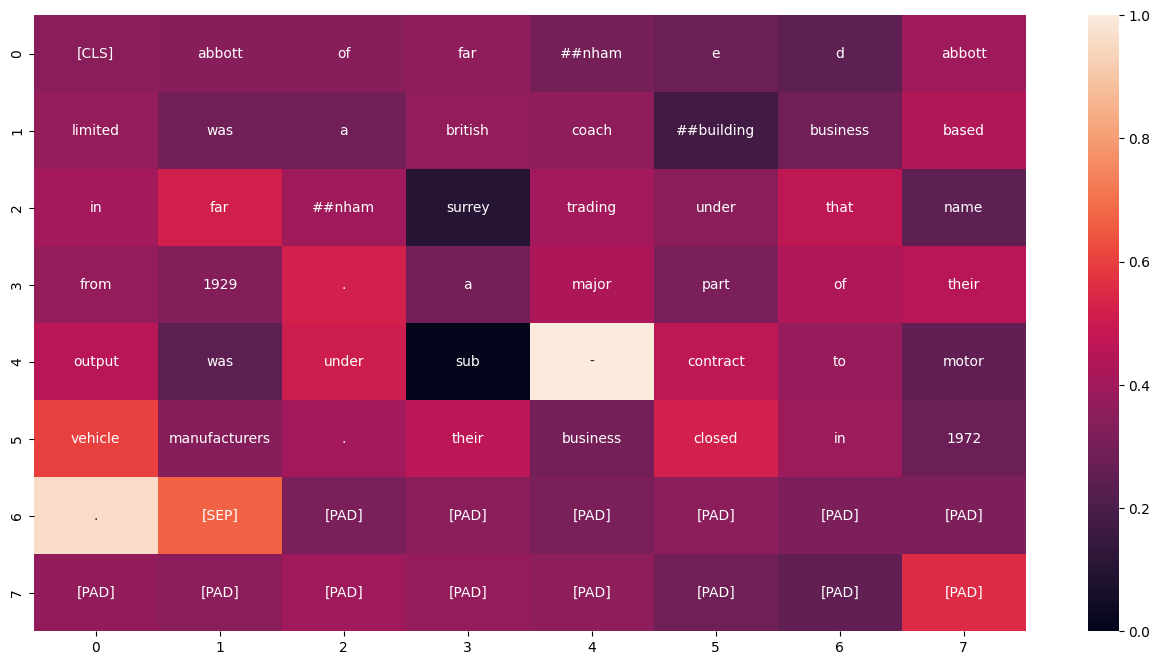

In [12]:
import numpy as n
import matplotlib.pyplot as p
import seaborn as s
attribution = attribution.sum(axis=-1)
min_ = attribution.min()
max_ = attribution.max()
attribution = (attribution - min_) / (max_ - min_)

# creating random data using numpy
df = n.array([attribution])
df = df.reshape(8,8)

# creating text array using numpy
tx = n.array([tokenizer.decode(token_x[0,i]) for i in range(len(token_x[0]))])
tx = tx.reshape(8,8)

# creating subplot
figure, axx = p.subplots(figsize=(16, 8))
 
# defining heatmap on current axes using seaborn 
axx = s.heatmap(df, annot=tx, fmt="")